In [90]:
import dotenv
import os
from pymongo import MongoClient

# 환경변수 불러오기
dotenv.load_dotenv(dotenv.find_dotenv())
USER = os.environ["MONGODB_USER"] # MongoDB user
PASSWORD = os.environ["MONGODB_PW"] # MongoDB password
PORT = int(os.environ["MONGODB_PORT"]) # MongoDB port

# DB 연결
client = MongoClient("mongodb://" + USER + ":" + PASSWORD + "@j7e104.p.ssafy.io", PORT)

db = client.test
dbcol_review = db.review
dbcol_detail = db.ani_detail

In [91]:
from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import numpy as np
import pandas as pd

In [92]:
# 애니 정보 불러오기
ani_df = pd.DataFrame(dbcol_detail.find({},{"id":1, "name":1}))
ani_df.columns = ["_id", "animation", "ani_name"]
ani_df

,_id,animation,ani_name
0,6322bfd5db337b16410bfe29,39986,주술회전 part 1
1,6322bfd5db337b16410bfe2b,39431,(무삭제) 귀멸의 칼날
2,6322bfd6db337b16410bfe2d,16075,은혼 1기
3,6322bfd6db337b16410bfe2f,38912,전생했더니 슬라임이었던 건에 대하여 1기
4,6322bfd6db337b16410bfe31,40562,귀멸의 칼날 : 환락의 거리편
...,...,...,...
6116,6322c3c0db337b16410c38e4,40821,처형 소녀의 살아가는 길
6117,6322c3c0db337b16410c38e6,40875,코타로는 1인 가구
6118,6322c3c0db337b16410c38e8,40921,이세계 삼촌
6119,6322c3c0db337b16410c38ea,40974,명탐정 코난 : 할로윈의 신부


In [95]:
# 평가 데이터 불러오기
profile = list(dbcol_review.find({}))
rating_df = pd.DataFrame(profile)
rating_df = rating_df[["animation", "profile", "score"]]
rating_df["profile"] = rating_df["profile"].map(lambda x:x["id"])
rating_df.columns = ["animation", "user_id", "score"]
print(rating_df)
drop_index = rating_df[rating_df['score'] == 0].index
print(drop_index)
rating_df.drop(drop_index, inplace=True)
print(rating_df)

        animation  user_id  score
0           39986  4523846    5.0
1           39986  2976649    3.5
2           39986  4759828    5.0
3           39986   134827    5.0
4           39986  5873764    5.0
...           ...      ...    ...
392283      39986    16079    5.0
392284      39986   192283    5.0
392285      39986  1148935    0.0
392286      39986   617649    0.0
392287      39986    49901    5.0

[392288 rows x 3 columns]
Int64Index([    30,     42,     72,    103,    180,    185,    219,    237,
               252,    282,
            ...
            392255, 392260, 392261, 392266, 392270, 392276, 392277, 392280,
            392285, 392286],
           dtype='int64', length=108063)
        animation  user_id  score
0           39986  4523846    5.0
1           39986  2976649    3.5
2           39986  4759828    5.0
3           39986   134827    5.0
4           39986  5873764    5.0
...           ...      ...    ...
392281      39986   865729    5.0
392282      39986  2754128 

In [96]:
ani_ratings = pd.merge(ani_df, rating_df, left_on='animation', right_on='animation')
ani_ratings.head()

,_id,animation,ani_name,user_id,score
0,6322bfd5db337b16410bfe29,39986,주술회전 part 1,4523846,5.0
1,6322bfd5db337b16410bfe29,39986,주술회전 part 1,2976649,3.5
2,6322bfd5db337b16410bfe29,39986,주술회전 part 1,4759828,5.0
3,6322bfd5db337b16410bfe29,39986,주술회전 part 1,134827,5.0
4,6322bfd5db337b16410bfe29,39986,주술회전 part 1,5873764,5.0


In [97]:
print(ani_df.shape) # (6121, 3)

print(rating_df.shape) # (284225, 3)

print(ani_ratings.shape) # (284225, 5)

(6121, 3)
(284225, 3)
(284225, 5)


In [98]:
ani_ratings["animation"].nunique()
# 4586
# ani가 6121개 있으나 평가가 있는 ani는 4586개 (평점을 남기지 않고도 댓글을 달 수 있기에 더 차이가 생김)
# 1535개의 ani는 평가 혹은 평점이 없음

4586

In [99]:
ani_ratings["user_id"].nunique()
# 91430
# 91430명의 사용자가 6121개의 애니에 대해 284225 평가를 남긴 것을 알 수 있음

91430

In [100]:
# 애니를 중심으로 평점을 보기 위한 데이터 프레임 생성
ani_rating_summary = ani_ratings[["animation", "score"]].groupby(["animation"]).agg(["count", "median", "mean"])
# score 안에 count, median, mean으로 멀티 인덱스이므로 수정
ani_rating_summary.columns = ["count", "median", "mean"]
ani_rating_summary.head()

,count,median,mean
animation,,,
164,8,5.0,4.812500
9450,64,5.0,4.773438
10072,64,5.0,4.835938
11876,854,5.0,4.731850
12912,17,3.0,3.029412


In [101]:
#가장 많은 평점을 받은 애니 Top10
ani_rating_summary.sort_values("count", ascending=False).head(10)

,count,median,mean
animation,,,
39654,3945,5.0,4.666793
40859,3777,5.0,4.963595
40815,3308,5.0,4.917624
39986,3154,5.0,4.739379
40860,2224,5.0,4.974595
40655,2081,5.0,4.828928
40157,1936,5.0,4.802428
24217,1711,5.0,4.795149
40562,1687,5.0,4.867516


In [106]:
#평점의 평균이 높은 순으로 애니 10개 출력
#but!출력물을 보면 알 수 있겠지만 이렇게하면 평점을 1개만 받았는데 5점이라서 출력되는 결과 발생
ani_rating_summary.sort_values("mean", ascending=False).head(10)

,count,median,mean
animation,,,
41053,2,5.0,5.0
15617,4,5.0,5.0
38998,1,5.0,5.0
38996,1,5.0,5.0
38993,2,5.0,5.0
38991,1,5.0,5.0
38989,1,5.0,5.0
38983,1,5.0,5.0
15650,3,5.0,5.0


In [103]:
#위의 문제를 해결하기 위해 평점의 갯수가 50개 이상인 애니 중에서 평점 평균이 높은 애니 Top10출력
ani_rating_summary[ani_rating_summary["count"] >= 50].sort_values("mean", ascending=False).head(10)

,count,median,mean
animation,,,
40998,106,5.0,5.000000
40872,64,5.0,4.992188
40860,2224,5.0,4.974595
40863,921,5.0,4.972856
40632,126,5.0,4.972222
40861,1590,5.0,4.967925
39000,118,5.0,4.966102
40859,3777,5.0,4.963595
40825,1232,5.0,4.956169


C:\ProgramData\Anaconda3\envs\mecab\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\mecab\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


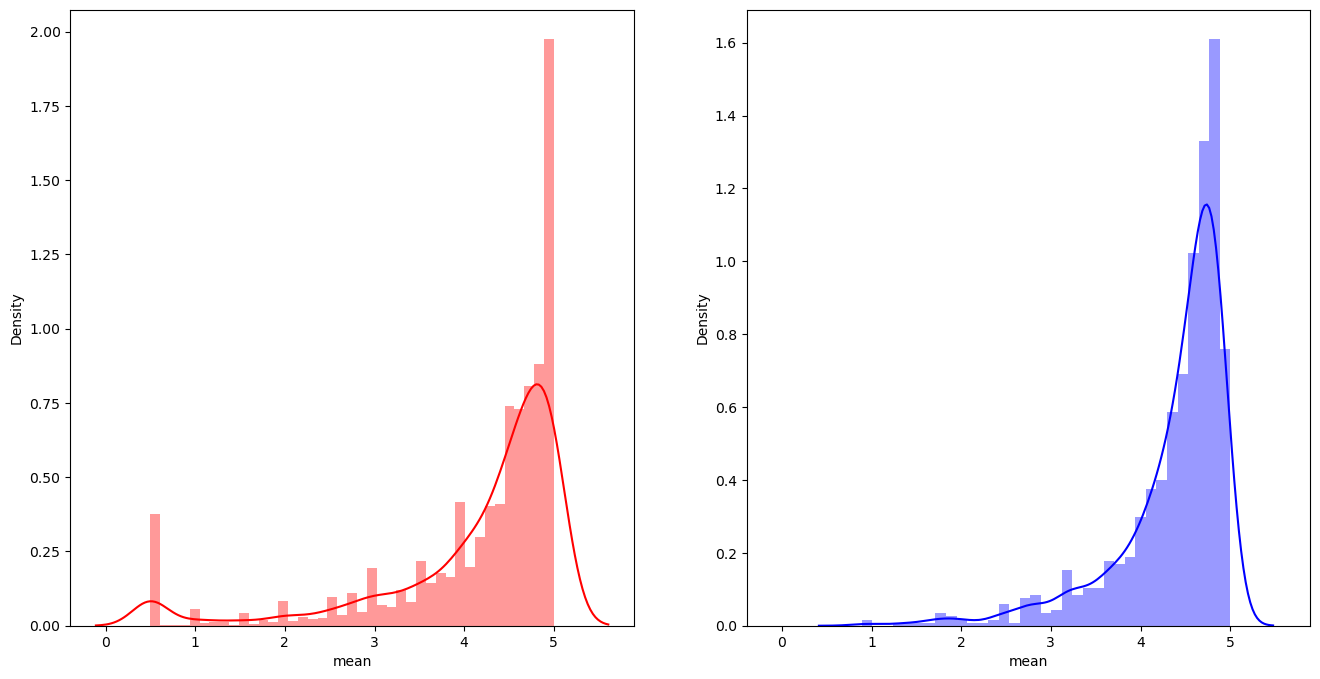

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
# 아래의 첫 번째 그래프를 보았을 때 5점의 비율이 높음을 알 수 있음.
# 평가 수가 적은 애니가 존재하기에 50개 이상의 평가가 있는 것만으로 진행.
sns.distplot(ani_rating_summary['mean'], kde=True, color='r', ax=axes[0])
# 0.5점은 주로 평가가 적은 애니에서 발생함을 알 수 있음.
sns.distplot(ani_rating_summary[ani_rating_summary["count"] >= 50]['mean'], kde=True, color='b', ax=axes[1])
# 그래프가 약간 오른쪽으로 치우진 것을 보았을 때 상대적으로 후하게 평점을 줌을 알 수 있음.
plt.show()

In [107]:
#사용자를 중심으로 평점 정보를 보기 위한 데이터 프레임 생성
user_rating_summary = ani_ratings[["user_id", "score"]].groupby(["user_id"]).agg(["count", "median", "mean"])
user_rating_summary.columns = ["count", "median", "mean"]
user_rating_summary.head()

,count,median,mean
user_id,,,
15,4,5.0,4.750000
23,41,5.0,3.878049
34,1,5.0,5.000000
122,11,5.0,5.000000
128,1,5.0,5.000000


In [108]:
#가장 많이 평점을 작성한 사용자 Top10
user_rating_summary.sort_values("count", ascending=False).head(10)

#가장 평점을 후하게 준 사용자 Top10
# user_rating_summary.sort_values("median", ascending=False).head(10)
#가장 평점을 짜게 준 사용자 Top10
# user_rating_summary.sort_values("median", ascending=True).head(10)

,count,median,mean
user_id,,,
592448,715,4.0,3.881818
2367974,629,3.0,3.034181
339351,404,4.0,3.329208
3940383,363,2.0,2.342975
4560470,353,5.0,4.917847
963737,339,3.5,3.530973
3075034,339,4.0,3.737463
1310433,318,5.0,4.918239
1483274,300,5.0,4.930000


영화 데이터를 surprise 모듈을 통해 로딩

In [109]:
# animation를 기준으로 애니의 이름 return
def getAniName(ani_ratings, aniID):
    return ani_ratings[ani_ratings["animation"] == aniID][["ani_name"]].values[0]

# ani이름을 기준으로 애니의 ID return
def getAniID(ani_ratings, aniName):
    return ani_ratings[ani_ratings["ani_name"] == aniName][["animation"]].values[0]

In [110]:
df = pd.DataFrame(ani_ratings, columns=['user_id', 'animation', 'score'])
df

,user_id,animation,score
0,4523846,39986,5.0
1,2976649,39986,3.5
2,4759828,39986,5.0
3,134827,39986,5.0
4,5873764,39986,5.0
...,...,...,...
284220,1842830,23801,4.5
284221,927797,23801,4.5
284222,2072766,23801,5.0
284223,1019844,23801,4.0


In [154]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# 데이터 변환
# reader = Reader(rating_scale=(0.5, 5))
# data = Dataset.load_from_df(df, reader)
reader = Reader(line_format = 'user item rating', rating_scale=(0,5))
data = Dataset.load_from_df(df[['user_id', 'animation', 'score']], reader)

from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate


# Creation of the dataframe. Column names are irrelevant.
# ratings_dict = {
#     "itemID": [1, 1, 1, 2, 2],
#     "userID": [9, 32, 2, 45, "user_foo"],
#     "rating": [3, 2, 4, 3, 1],
# }
# df1 = pd.DataFrame(ratings_dict)
# print(df1)
# print(df1(df1[['itemID']]))
# print(ani_ratings)
df = ani_ratings[['user_id', 'animation', 'score']]
# df = pd.DataFrame(ani_ratings, columns=['user_id', 'animation', 'score'])
# print(df)

# DF = pd.DataFrame()
# for key in user_dict.keys():
#     df = pd.DataFrame(columns=['User', 'Item', 'Rating'])
#     df['Rating'] = pd.Series(user_dict[key])
#     df['Item'] = pd.DataFrame(df.index)
#     df['User'] = key

#     DF = pd.concat([DF, df], axis = 0)

# DF = DF.reset_index(drop=True)

# # A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5.0))

# # The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[["user_id", "animation", "score"]], reader)

trainset, testset = train_test_split(data, test_size=0.25, random_state=0)

algo = SVD(n_factors=50, random_state=13)
algo.fit(trainset)
predictions = algo.test(testset)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 5, verbose = True)
# # # We can now use this dataset as we please, e.g. calling cross_validate
# cross_validate(NormalPredictor(), data, cv=2)

# # 훈련 및 테스트 데이터 분리
# trainset, testset = train_test_split(data, test_size=.25, random_state=0)
 
# # 수행시마다 동일한 결과 도출을 위해 random_state 설정
# algo = SVD(n_factors=50, random_state=0)
 
# # 학습 데이터 세트로 학습 후 테스트 데이터 세트로 평점 예측 후 RMSE 평가
# algo.fit(trainset)
# predictions = algo.test(testset)
# print(predictions[:1000])
# # predictions.na().drop()
# # accuracy.rmse(predictions)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2430  nan     nan     1.2379  nan     nan     nan     
MAE (testset)     0.5410  nan     nan     0.5421  nan     nan     nan     
Fit time          1.96    2.00    2.10    2.03    2.06    2.03    0.05    
Test time         0.26    0.26    0.26    0.27    0.28    0.26    0.01    


{'test_rmse': array([1.24301019,        nan,        nan, 1.2379048 ,        nan]),
 'test_mae': array([0.54104143,        nan,        nan, 0.54211452,        nan]),
 'fit_time': (1.9617784023284912,
  1.9983758926391602,
  2.0993916988372803,
  2.025761365890503,
  2.0639355182647705),
 'test_time': (0.25748324394226074,
  0.2567570209503174,
  0.2593071460723877,
  0.2653205394744873,
  0.276033878326416)}

In [124]:
from surprise import KNNBasic
import heapq
from collections import defaultdict
from surprise.dataset import DatasetAutoFolds

# from surprise import SVD
# from surprise import NormalPredictor
# from surprise.model_selection import GridSearchCV

#build_full_trainset() : train/test set으로 나누지말고 전부 train set으로
# trainSet = df.build_full_trainset()
trainSet = df

#유사도 측정함수의 속성
sim_options = {
    'name': 'cosine',	#코사인 유사도
    'user_based': True	#사용자 기반 협업 필터링
}

model = KNNBasic(sim_options=sim_options)
model.fit(trainSet)
simsMatrix = model.compute_similarities()

In [23]:
testUser = '85'
k = 10

# 주어진 사용자와 가장 흡사한 사용자 N을 찾는다
# 먼저 이를 Surprise 내부 ID로 변환
testUserInnerID = trainSet.to_inner_uid(testUser)
print(testUserInnerID)
#84

# 이 사용자에 해당하는 레코드를 읽어온다
similarityRow = simsMatrix[testUserInnerID]

84


In [24]:
# users에 모든 사용자들을 일련번호와 유사도를 갖는 튜플의 형태로 저장
# 이 때 본인은 제외
users = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        users.append( (innerID, score) )

# 이제 users 리스트에서 유사도 값을 기준으로 가장 큰 k개를 찾는다
kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1])

kNeighbors
'''
[(10,1.0),
 (11,1.0),
 (13,1.0),
 (24,1.0),
 (36,1.0),
 (44,1.0),
 (45,1.0),
 (51,1.0),
 (53,1.0),
 (61,1.0)]
'''
#(사용자ID, 유사도)
#즉, 85번 사용자와 100%일치하는 사용자 10명이 출력된 것

'\n[(10,1.0),\n (11,1.0),\n (13,1.0),\n (24,1.0),\n (36,1.0),\n (44,1.0),\n (45,1.0),\n (51,1.0),\n (53,1.0),\n (61,1.0)]\n'

In [25]:
# 이제 유사 사용자들을 하나씩 보면서 그들이 평가한 아이템들별로 원 사용자와 유사 사용자간의 유사도를 가중치로 준 평점을 누적한다

# candidates에는 아이템별로 점수를 누적한다. 유사사용자(u')의 평점 * 사용자(u)와 유사 사용자(u')의 유사도
candidates = defaultdict(float)

# 이 K명의 최고 유사 사용자를 한명씩 루프를 돌면서 살펴본다
for similarUser in kNeighbors:
    # similarUser는 앞서 enumerate로 만든 그 포맷임 - (내부ID, 유사도값)
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]

    # innerID에 해당하는 사용자의 아이템과 평점 정보를 읽어온다.
    # theirRatings는 (아이템ID, 평점)의 리스트임
    theirRatings = trainSet.ur[innerID]
    # innerID가 평가한 모든 아이템 리스트를 하나씩 보면서 
    # 아이템ID별로 평점 정보를 합산하되 사용자와의 유사도값을 가중치로 준다
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1]) * userSimilarityScore
        
# 사용자가 이미 평가한 아이템들을 제거할 사전을 만든다
watched = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1

In [26]:
# 앞서 candidates에서 합산된 스코어를 기준으로 내림차순으로 소팅한 후
# 사용자(u)가 아직 못본 아이템인 경우 추천한다
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True):
    if not itemID in watched:
        movieID = trainSet.to_raw_iid(itemID)
        print(movieID, getMovieName(movie_ratings, int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0


In [27]:
# 앞의 testUser = '85'부터 코드를 함수로 만든 것
def recommendForUser(userID):
    testUserInnerID = trainSet.to_inner_uid(userID)
    similarityRow = simsMatrix[testUserInnerID]

    users = []
    for innerID, score in enumerate(similarityRow):
        if (innerID != testUserInnerID):
            users.append( (innerID, score) )

    kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1])

    candidates = defaultdict(float)
    for similarUser in kNeighbors:
        innerID = similarUser[0]
        userSimilarityScore = similarUser[1]
        theirRatings = trainSet.ur[innerID]
        for rating in theirRatings:
            candidates[rating[0]] += (rating[1]) * userSimilarityScore

    watched = {}
    for itemID, rating in trainSet.ur[testUserInnerID]:
        watched[itemID] = 1

    pos = 0
    for itemID, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True):
        if not itemID in watched:
            movieID = trainSet.to_raw_iid(itemID)
            print(movieID, getMovieName(movie_ratings, int(movieID)), ratingSum)
            pos += 1
            if (pos > 10):
                break

recommendForUser('85')

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0
